In [10]:
# imports and stuff
import gymnasium as gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir,Ridge,FORCE,LMS,NVAR
import sklearn
import time

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            #self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.device = torch.device('cpu')
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    ).to(self.device)
            self.optimizer = torch.optim.RMSprop(self.model.parameters(),lr)
            #self.optimizer = torch.optim.AdamW(self.model.parameters(),lr)
    
    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        
        y_pred = self.model(torch.Tensor(state))
        
        loss = self.criterion(y_pred, torch.Tensor(y)).to(self.device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.tensor(state).unsqueeze(dim=0).float().to(self.device))
class DQRC():
    ''' Reservoir Computing Q-Learning Class '''
    def __init__(self,n_state, n_action,esn=True, lr=0.05,n_nodes=1000):
        self.esn = esn
        if esn:
            rc_connect = 0.1
            leak_rate = 0.5
            #ridge = Ridge(output_dim=n_action,ridge=lr)
            ridge = LMS(output_dim=n_action,alpha=lr)
        else:
            rc_connect = 0
            leak_rate = 1
            ridge = LMS(output_dim=n_action,alpha=lr)
            #ridge = Ridge(output_dim=n_action,ridge=1e-7)
        reservoir = Reservoir(input_dim=n_state,units=n_nodes, lr=leak_rate, sr=0.9,rc_connectivity=rc_connect,activation='relu') # makes it into an ELM
        #reservoir = Reservoir(input_dim=n_state,units=1000, lr=leak_rate, sr=0.9,rc_connectivity=rc_connect) # makes it into an ELM
        #ridge = Ridge(output_dim=n_action,ridge=1e-7)
        #reservoir = NVAR(delay=2, order=2, strides=1,input_dim=n_state)
        
        self.model = reservoir >> ridge
        
    
    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        if self.esn:
            self.reset()
        state = np.array(state)
        y = np.array(y)
        #y_pred = self.model.predict(state)
        if len(state.shape)==1:
            state = state.reshape(1, -1)
            y = y.reshape(1, -1)
            self.model.train(state,y)
        else:
            self.model.train(state,y)
        #print(state)
        #print(y)
        
    def reset(self):
        self.model.reset()
    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        if self.esn:
            self.reset()
        state = np.array(state)
        if len(state.shape)==1:
            state = state.reshape(1, -1)
            return self.model.call(state)
        else:
            return self.model.run(state)
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = np.array(batch_t[0])
            actions = batch_t[1]
            next_states = np.array(batch_t[2])
            rewards = batch_t[3]
            is_dones = batch_t[4]
    
            #actions = torch.Tensor(actions).to(self.device)
        
            #is_dones_indices = list(np.where(is_dones==True))
            is_dones_indices = np.where(is_dones==True)[0]
            #print(is_dones_indices)
        
            all_q_values = np.array(self.model.run(states)) # predicted q_values of all states
            all_q_values_next = self.model.run(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*np.max(all_q_values_next, axis=1)
            for index in list(is_dones_indices):
                all_q_values[index, list(actions[is_dones])]=rewards[index]
        
            
            self.update(np.array(states.tolist()), np.array(all_q_values.tolist()))
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True,rc=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        # Reset state
        state = env.reset()[0]
        done = False
        total = 0
        if rc:
            model.reset()
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                if rc:
                    q_values = model.predict(state)
                    action = np.argmax(q_values)
                else:
                    q_values = model.predict(state)
                    action = torch.argmax(q_values).item()
            #print(action)
            
            # Take action and add reward to total
            next_state, reward, done, truncated , _= env.step(action)
            done = done or truncated
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))

            q_values = model.predict(state)[0]
            #print(q_values)
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                if rc:
                    q_values_next = model.predict(next_state)
                else:
                    q_values_next = model.predict(next_state)
                if not rc:
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                else:
                    q_values[action] = reward + gamma * np.max(q_values_next)
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    # [King Crimson!] What you saw is your previous self. Now experience
    # the sweet sublime oblivion of death!
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
            #actions = torch.Tensor(actions).to(self.device)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())
def q_learning_parametricized(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True,n_actions = 10):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()[0]
        done = False
        total = 0
        
        # new action space - [-2,-1,0,1,2] - n= 5
        action_space = list(np.linspace(-2,2,n_actions,True))
        action_index = 0
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action_index = random.choice(range(n_actions))
            else:
                q_values = model.predict(state)
                action_index = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            #print(action_index)
            #print(action_space)
            #print(action_space[action_index])
            #action = np.array(action_space[action_index], like=np.empty((1,)) )
            action = [action_space[action_index]]
            #action = [np.array(-1.324, like=np.empty((1,)) )]
            next_state, reward, done, truncated , _= env.step(action)
            done = done or truncated
            # Update total and memory
            total += reward
            memory.append((state, action_index, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action_index] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action_index] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final
# Expand DQL class with a replay function.
def get_screen(env):
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

In [2]:
# various parameters and initializations 
episodes = 500
# Number of hidden nodes in the DQN
n_hidden = 128
# Learning rate
lr = 0.001


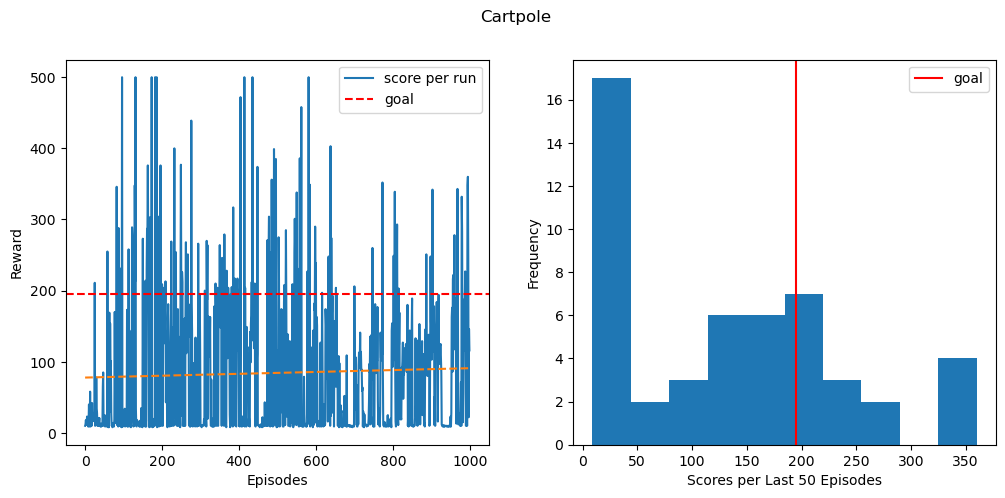

episode: 1000, total reward: 116.0


In [25]:
### DQN-Replay Cartpole ### 
env = gym.envs.make("CartPole-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, episodes,epsilon=0.2, gamma=.9, replay=False, title='Cartpole')

In [ ]:
### ESNQ Cartpole ### 
env = gym.envs.make("CartPole-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dqn_replay = DQRC(n_state, n_action,esn=False,lr=5e-3,n_nodes=1000)
replay = q_learning(env, dqn_replay, episodes, epsilon=0.2,gamma=.9, replay=False, title='Cartpole',rc=True)

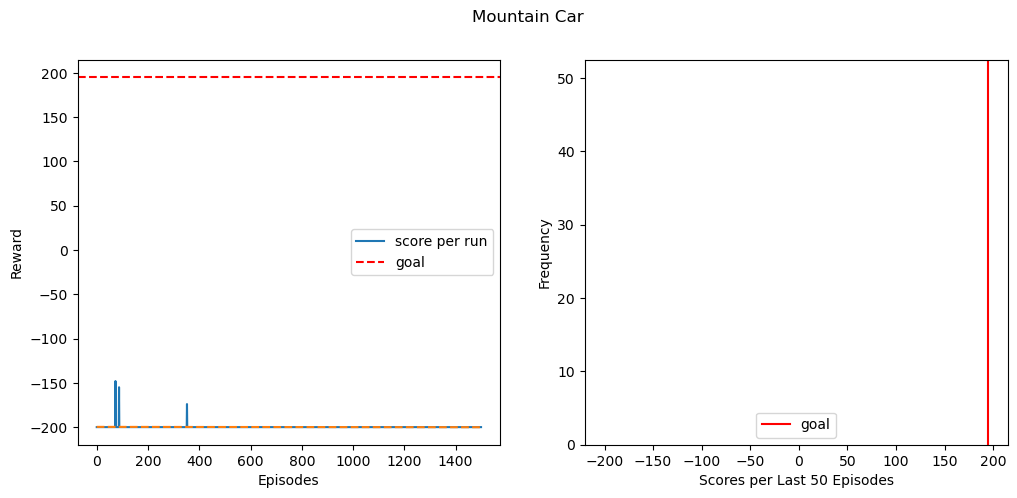

episode: 1500, total reward: -200.0


In [12]:
### DQN-Replay Mountain Car ### 
env = gym.envs.make("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, episodes=1500, gamma=.995, epsilon=0.5, replay=False, title='Mountain Car')

In [ ]:
### RC Mountain Car ### 
env = gym.envs.make("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dqn_replay = DQRC(n_state, n_action,esn=False,lr=5e-3,n_nodes=1000)
replay = q_learning(env, dqn_replay, episodes=1500, epsilon=0.5,gamma=.995, replay=False, title='RC Mountain Car',rc=True)

In [ ]:
### Acrobat ### 
env = gym.envs.make("Acrobot-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dqn_replay = DQN_replay(n_state, n_action, 256, 0.01)
replay = q_learning(env, dqn_replay, 1000, gamma=.95, epsilon=1, replay=False, title='DQN Acrobat')

In [ ]:
### RC Acrobat ### 
env = gym.envs.make("Acrobot-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dqn_replay = DQRC(n_state, n_action,esn=False,lr=5e-3,n_nodes=1000)
replay = q_learning(env, dqn_replay, episodes=1500, epsilon=0.5,gamma=.995, replay=False, title='RC Acrobat',rc=True)

In [22]:
### Pendulum ### 
env = gym.envs.make("Pendulum-v1")
n_state = env.observation_space.shape[0]
n_action = 10
dqn_replay = DQN_replay(n_state, n_action, 32, lr)
replay = q_learning_parametricized(env, dqn_replay, 200, gamma=.90, epsilon=0.2, replay=False, title='Pendulum',n_actions=n_action)

IndexError: list assignment index out of range